In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
import os
from tkinter import ttk, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [4]:
# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

for dirname, _, filenames in os.walk('data_base'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data_base\US_Accidents_March23.csv


In [5]:
# Cargar el conjunto de datos
data = pd.read_csv('data_base/US_Accidents_March23.csv', usecols=['City', 'Sunrise_Sunset', 'Severity', 'Weather_Condition'])

In [6]:
# Funciones matemáticas
def gauss_seidel(a, b, x0=None, tol=1e-6, max_iter=100):
    n = len(b)
    x = x0 or [0] * n
    for _ in range(max_iter):
        x_new = x[:]
        for i in range(n):
            s1 = sum(a[i][j] * x_new[j] for j in range(i))
            s2 = sum(a[i][j] * x[j] for j in range(i+1, n))
            x_new[i] = (b[i] - s1 - s2) / a[i][i]
        if max(abs(x_new[i] - x[i]) for i in range(n)) < tol:
            return x_new
        x = x_new
    return x

def ajustar_minimos_cuadrados(X, Y):
    A = [[sum(x**p for x in X) for p in range(3)] for _ in range(3)]
    for i in range(3):
        for j in range(3):
            A[i][j] = sum(x**(i + j) for x in X)
    b = [sum(y * (x**i) for x, y in zip(X, Y)) for i in range(3)]
    coeficientes = gauss_seidel(A, b)
    return coeficientes  # [a0, a1, a2] para ax² + bx + c

In [13]:
CIUDADES_VALIDAS = [
    'Los Angeles', 'New York', 'Dayton', 'Chicago', 'Atlanta', 'Philadelphia',
    'San Antonio', 'San Diego', 'Dallas', 'San Jose', 'Austin', 'Miami',
    'Fort Worth', 'Columbus', 'San Francisco', 'Orlando', 'Indianapolis',
    'Seattle', 'Denver', 'Washington', 'Nashville', 'Oklahoma City', 'Boston',
    'El Paso', 'Portland', 'Las Vegas', 'Detroit', 'Memphis', 'Louisville',
    'Milwaukee', 'Albuquerque', 'Tucson'
]

CLIMAS_VALIDOS = [
    'Clear', 'Cloudy', 'Rain', 'Fog', 'Snow', 'Thunderstorm'
]

CLIMAS = {
    'Clear': 'Despejado',
    'Cloudy': 'Nublado',
    'Rain': 'Lluvia',
    'Fog': 'Niebla',
    'Snow': 'Nieve',
    'Thunderstorm': 'Tormenta Eléctrica'
}

def cargar_datos(data):
    try:
        # Filtrar por ciudades válidas
        data = data[data['City'].isin(CIUDADES_VALIDAS)].dropna()

        # Filtrar por climas válidos
        data = data[data['Weather_Condition'].isin(CLIMAS_VALIDOS)]

        # Calcular "Momento" (día o noche) a partir de la hora
        data['Moment'] = data['Sunrise_Sunset'].apply(lambda x: 'Día' if x == 'Day' else 'Noche')

        # Convertir gravedad a entero (por si viene como float)
        data['Severity'] = data['Severity'].astype(int)

        # Seleccionar columnas necesarias
        data_final = data[['City', 'Weather_Condition', 'Moment', 'Severity']]

        # Convertir a lista de diccionarios si deseas mantener la compatibilidad con tu código anterior
        return data_final.to_dict('records')

    except Exception as e:
        print("Error cargando el archivo:", e)
        return []

def predecir_gravedad(ciudad, clima, momento, datos):
    filtrados = [d for d in datos if
                 d['City'] == ciudad and
                 d['Weather_Condition'] == clima and
                 d['Moment'] == momento]

    if not filtrados or len(filtrados) < 3:
        return None, []

    # Crear eje X como índice simple (0, 1, 2, ...)
    X = list(range(len(filtrados)))
    Y = [d['Severity'] for d in filtrados]

    # Obtener coeficientes por mínimos cuadrados + Gauss-Seidel
    coef = ajustar_minimos_cuadrados(X, Y)

    # Predecir gravedad para siguiente punto (len(X)) usando ax² + bx + c
    x_pred = len(X)
    prediccion = coef[0] + coef[1]*x_pred + coef[2]*(x_pred**2)
    return prediccion, (X, Y, coef)

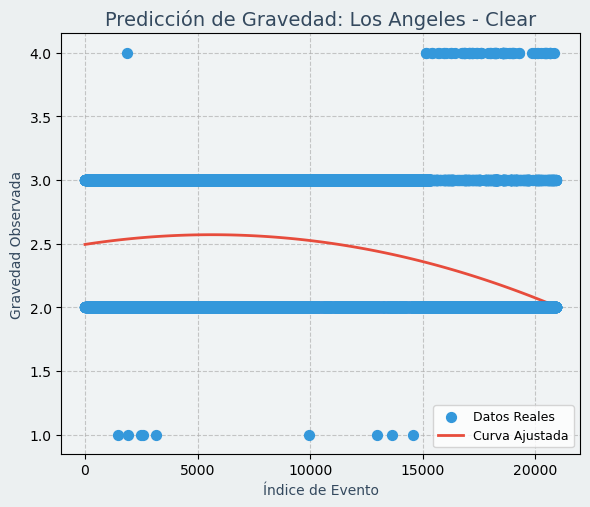

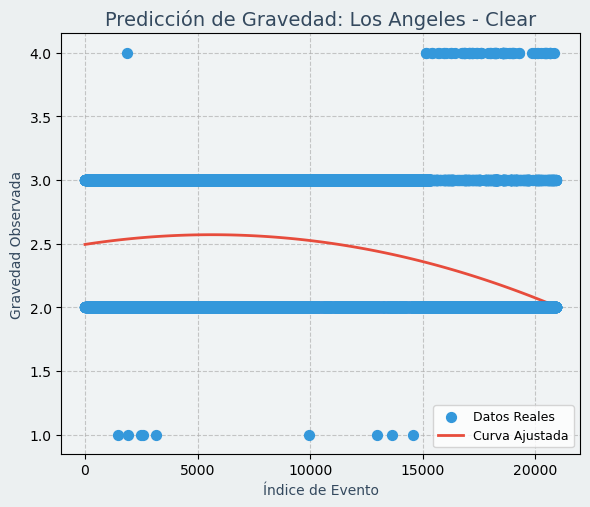

In [15]:
# --- Interfaz de usuario ---
def crear_interfaz(datos):
    root = tk.Tk()
    root.title("Predicción de Accidentes")
    root.geometry("600x400") # Tamaño inicial de la ventana
    root.configure(bg='#2C3E50') # Color de fondo oscuro

    # Estilo de la fuente para toda la aplicación
    root.option_add("*Font", "Arial 12")

    # Estilo de los widgets
    style = ttk.Style()
    style.theme_use('clam') # Un tema más moderno

    style.configure("TLabel", background='#2C3E50', foreground='#ECF0F1', font=("Arial", 12))
    style.configure("TButton", background='#3498DB', foreground='white', font=("Arial", 12, "bold"), borderwidth=0)
    style.map("TButton", background=[('active', '#2980B9')])
    style.configure("TCombobox", fieldbackground='#ECF0F1', background='#34495E', foreground='#2C3E50', font=("Arial", 11))
    style.map("TCombobox", fieldbackground=[('readonly', '#ECF0F1')]) # Asegurar que el fondo del combobox sea claro

    # --- Frame para la selección inicial ---
    input_frame = tk.Frame(root, bg='#2C3E50', padx=20, pady=20)
    input_frame.pack(expand=True, fill='both')

    # Título principal
    title_label = tk.Label(input_frame, text="Sistema de Predicción de Accidentes",
                           font=("Arial", 20, "bold"), fg='#E74C3C', bg='#2C3E50')
    title_label.pack(pady=20)

    # Ciudad
    tk.Label(input_frame, text="Seleccione la Ciudad:", bg='#2C3E50', fg='#ECF0F1').pack(pady=5)
    ciudad_combo = ttk.Combobox(input_frame, values=CIUDADES_VALIDAS, width=30, state="readonly")
    ciudad_combo.pack(pady=5)
    ciudad_combo.set("Los Angeles") # Valor por defecto

    # Clima
    tk.Label(input_frame, text="Seleccione la Condición Climática:", bg='#2C3E50', fg='#ECF0F1').pack(pady=5)
    # Obtenemos los valores en español para mostrar en el Combobox
    climas_para_mostrar = [CLIMAS[c] for c in CLIMAS_VALIDOS]
    clima_combo = ttk.Combobox(input_frame, values=climas_para_mostrar, width=30, state="readonly")
    clima_combo.pack(pady=5)
    clima_combo.set(CLIMAS['Clear']) # Valor por defecto

    # Hora
    tk.Label(input_frame, text="Seleccione el Momento del Día:", bg='#2C3E50', fg='#ECF0F1').pack(pady=5)
    momento_combo = ttk.Combobox(input_frame, values=['Día', 'Noche'], width=30, state="readonly")
    momento_combo.pack(pady=5)
    momento_combo.set("Día") # Valor por defecto

    # --- Función para mostrar la pantalla de resultados ---
    def mostrar_resultados_pantalla(ciudad, clima, momento, pred, X, Y, coef):
        # Crear una nueva ventana para los resultados
        result_window = tk.Toplevel(root)
        result_window.title(f"Resultados de Predicción - {ciudad}")
        result_window.geometry("900x600")
        result_window.configure(bg='#34495E') # Fondo para la ventana de resultados

        # Frame principal para la ventana de resultados
        main_result_frame = tk.Frame(result_window, bg='#34495E')
        main_result_frame.pack(expand=True, fill='both', padx=10, pady=10)

        # Frame para la gráfica
        graph_frame = tk.Frame(main_result_frame, bg='#ECF0F1', bd=2, relief="groove")
        graph_frame.pack(side='left', fill='both', expand=True, padx=10, pady=10)

        # Frame para los controles (resultado y botones)
        controls_frame = tk.Frame(main_result_frame, bg='#2C3E50', bd=2, relief="groove")
        controls_frame.pack(side='right', fill='y', padx=10, pady=10)

        # Título de la sección de resultados
        tk.Label(controls_frame, text="Detalles de la Predicción", font=("Arial", 14, "bold"),
                 fg='#F39C12', bg='#2C3E50').pack(pady=10)

        # Resultado de la predicción
        tk.Label(controls_frame, text=f"Ciudad: {ciudad}", font=("Arial", 12, "bold"), fg='#ECF0F1', bg='#2C3E50').pack(pady=2)
        tk.Label(controls_frame, text=f"Clima: {CLIMAS[clima]}", font=("Arial", 12, "bold"), fg='#ECF0F1', bg='#2C3E50').pack(pady=2)
        tk.Label(controls_frame, text=f"Momento del Día: {momento}", font=("Arial", 12, "bold"), fg='#ECF0F1', bg='#2C3E50').pack(pady=2)
        tk.Label(controls_frame, text=f"Gravedad Predicha: {pred:.2f}", font=("Arial", 12, "bold"), fg='#2ECC71', bg='#2C3E50').pack(pady=15)

        # Graficar
        fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
        ax.scatter(X, Y, label="Datos Reales", color='#3498DB', s=50, zorder=5) # Más grande, azul
        x_curve = np.linspace(min(X) if X else 0, max(X) + 2, 100)
        y_curve = coef[0] + coef[1]*x_curve + coef[2]*x_curve**2
        ax.plot(x_curve, y_curve, label="Curva Ajustada", color='#E74C3C', linewidth=2) # Rojo, más gruesa
        ax.set_title(f"Predicción de Gravedad: {ciudad} - {clima}", fontsize=14, color='#34495E')
        ax.set_xlabel("Índice de Evento", fontsize=10, color='#34495E')
        ax.set_ylabel("Gravedad Observada", fontsize=10, color='#34495E')
        ax.legend(fontsize=9)
        ax.grid(True, linestyle='--', alpha=0.7)
        fig.patch.set_facecolor('#ECF0F1') # Fondo de la figura
        ax.set_facecolor('#F0F3F4') # Fondo del área de la gráfica
        plt.tight_layout()

        canvas = FigureCanvasTkAgg(fig, master=graph_frame)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        canvas.draw()

        # Botones para volver a predecir o cerrar
        def volver_a_predecir():
            result_window.destroy() # Cierra la ventana actual de resultados

        def cerrar_aplicacion():
            root.destroy() # Cierra la ventana principal y todas las dependientes

        ttk.Button(controls_frame, text="Volver a Predecir", command=volver_a_predecir,
                   style="TButton").pack(pady=10, ipadx=10, ipady=5)
        ttk.Button(controls_frame, text="Cerrar Aplicación", command=cerrar_aplicacion,
                   style="TButton").pack(pady=10, ipadx=10, ipady=5)

    # --- Función para ejecutar la predicción y cambiar de pantalla ---
    def ejecutar_prediccion():
        ciudad = ciudad_combo.get()
        clima_espanol = clima_combo.get()
        clima = next(key for key, value in CLIMAS.items() if value == clima_espanol)
        momento = momento_combo.get()

        if not ciudad or not clima or not momento:
            messagebox.showerror("Error", "Por favor seleccione la Ciudad, el Clima y el Momento del Día.", parent=root)
            return

        pred, data_for_plot = predecir_gravedad(ciudad, clima, momento, datos)
        if pred is None or not data_for_plot:
            messagebox.showinfo("Información", "No hay suficientes datos históricos para realizar una predicción precisa con los criterios seleccionados.", parent=root)
            return

        X, Y, coef = data_for_plot
        mostrar_resultados_pantalla(ciudad, clima, momento, pred, X, Y, coef)

    # Botón de predicción inicial
    predict_button = ttk.Button(input_frame, text="Predecir Gravedad", command=ejecutar_prediccion, style="TButton")
    predict_button.pack(pady=20, ipadx=20, ipady=10) # Padding interno para el botón

    root.mainloop()

# --- Ejecución ---
if __name__ == "__main__":
    datos = cargar_datos(data)
    if datos:
        crear_interfaz(datos)
    else:
        messagebox.showerror("Error de Datos", "No se pudieron cargar los datos de accidentes. Por favor, revise el archivo 'US_Accidents_March23.csv' y la carpeta 'data_base'.")